In [35]:
import cv2
import numpy as np
import pandas as pd
from scipy.fftpack import dct
from skimage.feature import local_binary_pattern
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
import random
from sklearn.preprocessing import MinMaxScaler
import tqdm
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
!nvidia-smi

Thu Dec 16 23:28:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1259MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/'CV Project'/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CV Project


In [37]:
import torch
torch.cuda.is_available()

True

In [38]:
split_size = 16

In [39]:
def extract_features(folder, label):
    label_arr = []
    feature_vectors = []
    
    for file_name in tqdm(os.listdir(folder)):
        path = os.path.join(folder,file_name)
        image = cv2.imread(path, (5,5))
        if np.shape(img) == ():
            continue
        
        img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) 
        img = img[:,:,1] 
        height, width = img.shape
        
        i = 1
        X_points = [0]
        image_arr = []
        while True:
            pt = split_size * i
            image_temp = []
            if pt + split_size >= width:
                pt = width - split_size
                X_points.append(pt)
                image_temp.append(height)
                break
            image_arr.append(image_temp)
            X_points.append(pt)
            i += 1
        
        i = 1
        Y_points = [0]
        image_arr = []
        while True:
            pt = split_size * i
            image_temp = []
            if pt + split_size >= height:
                pt = height - split_size
                Y_points.append(pt)
                image_temp.append(height)
                break
            image_arr.append(image_temp)
            Y_points.append(pt)
            i += 1
        
        dct_blocks=[]
        for i in X_points:
            for j in Y_points:
                block = img[i:i+split_size, j:j+split_size]
                lbp = local_binary_pattern(block, 8, 1)
                dct_block = dct(lbp)
                dct_blocks.append(dct_block)

        np_dct_blocks = np.asarray(dct_blocks)
        
        std_features=[]
        for x in range(np_dct_blocks.shape[1]):
            for y in range(np_dct_blocks.shape[2]):
                std_feature = np.std(np_dct_blocks[:,x,y])
                std_features.append(std_feature)
        
        feature_vectors.append(img_std_list)
        label_arr.append(label)

In [41]:
labels=[]
features=[]

au_path="/scratch/ap6624/CV/CASIA2/Au"
tp_path="/scratch/ap6624/CV/CASIA2/Tp"
au_features, au_labels = extract_features(au_path, 0)
tp_features, tp_labels = extract_features(tp_path, 1)

features.extend(au_features)
features.extend(tp_features)

labels.extend(au_labels)
labels.extend(tp_labels)

100%|██████████| 5123/5123 [07:16<00:00, 11.74it/s]


In [42]:
print("Dimension of features", len(features[0]))
print("Length of feature vector", len(features))
print("length of label",len(labels))

Dimension of features 256
Length of feature vector 12614
length of label 12614


In [43]:
df=pd.DataFrame(features)

df_labels = pd.DataFrame(labels)

path_csv="CASIA2_feature_DCT_LBP_Blur.csv"
df.to_csv(path_csv, header=False, index=False)

path_labels_csv="CASIA2_feature_DCT_LBP_Blur_labels.csv"
df_labels.to_csv(path_labels_csv, header=False, index=False)

X = df.values[:,:]
y = df_labels.iloc[:].to_numpy()
print(X.shape)
print(y.shape)

df.head()

(12614, 256)
(12614, 1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,1662.152439,859.623118,782.490627,643.449104,462.217394,415.393369,359.928695,347.764556,331.343116,293.378557,274.043441,266.644416,248.971836,264.895582,247.870278,240.522068,1633.522785,798.432275,627.491262,510.182215,422.008278,422.100228,371.600446,356.269725,347.669063,328.360184,333.323159,322.248881,301.806632,286.947479,279.403943,268.335195,1729.231523,795.013302,597.299192,523.936944,447.742635,385.354785,386.020111,377.931851,...,333.860406,312.029333,309.177906,307.664615,291.654600,276.527329,268.323739,238.074012,1724.370650,740.334253,634.585365,518.289290,455.692595,394.701298,392.074622,352.164055,333.547274,319.050840,303.467229,281.762253,285.937621,297.803010,271.529171,266.552974,163.906952,84.612607,84.415503,76.991523,62.799491,51.734646,49.971807,45.837923,44.552900,48.308448,46.299038,43.949108,41.078114,38.505764,37.893634,36.911864
1,1735.504934,861.404337,719.121841,531.312427,401.879737,339.826660,315.050080,300.608291,285.530391,306.844539,252.486925,281.196403,289.029927,270.223889,263.325415,239.785855,1673.652203,728.482954,542.198060,439.252137,399.078551,355.969404,338.239618,331.062106,302.919831,309.476853,302.702180,293.481008,292.589397,288.628046,297.147087,288.175729,1710.919788,812.932832,561.973499,429.506909,351.971273,323.151622,301.822228,296.250074,...,306.416735,304.692315,292.347240,284.502498,248.042880,290.999679,273.594584,270.656533,1700.405368,714.701066,550.673370,439.742788,372.815880,349.860748,325.049756,323.763998,291.339291,316.243230,325.617593,311.969984,309.567762,293.856124,290.821785,312.435211,185.598664,94.760447,79.401590,64.048933,47.128409,40.227714,42.217411,38.440968,42.307052,41.481954,39.516820,40.593484,41.329991,39.142027,39.892446,39.383664
2,1491.038606,790.576273,710.167011,473.852576,393.201108,358.419859,370.997742,338.304577,321.029125,324.018651,313.763460,325.688376,348.040685,328.917851,328.475353,293.799563,1387.402276,642.199281,564.176425,437.996788,397.250601,401.269784,382.465002,353.068861,368.660207,371.650793,325.568533,341.194957,343.135665,332.989391,327.208044,313.511347,1507.912297,674.569458,514.033073,440.211589,382.857012,354.623368,363.164678,325.261072,...,342.934801,327.049695,332.884765,344.242347,317.394831,330.863335,322.549184,318.669273,1475.460742,650.095024,561.722939,423.535938,399.113303,377.634399,381.651079,346.848480,351.727554,345.405669,346.668901,337.853133,351.699096,354.178476,323.593620,346.307306,169.121401,94.714616,72.849106,55.670796,45.292712,43.559608,41.943288,40.938740,43.371739,45.075235,46.472219,45.846324,46.613019,45.502145,44.303755,47.027146
3,1362.681663,672.109632,625.113539,574.383064,557.034187,523.145423,516.640088,492.154540,459.979708,447.227424,405.095091,385.220243,341.427605,317.146114,307.004889,272.606987,1301.022580,656.032122,649.635885,624.185054,571.452213,548.346778,525.598634,491.069937,491.812947,439.393887,419.026494,389.121237,354.003838,317.414959,300.680163,291.727227,1275.124477,674.111097,654.914403,603.122839,554.579129,532.521386,539.388025,488.285846,...,489.032319,459.925160,430.906839,374.329348,345.782847,331.113971,297.684731,287.077616,1291.288469,684.673557,632.744873,582.229466,578.874318,551.292673,551.697747,501.769575,497.378587,474.965716,422.950854,380.330377,348.225981,331.888023,302.503830,281.613258,109.827685,63.591766,64.056394,60.920502,65.261808,70.975124,72.958045,71.158286,70.989512,66.910648,61.692686,56.350525,50.278816,47.734946,43.955880,41.792618
4,1832.381850,684.935684,598.971811,504.946900,480.260282,427.166707,407.707670,374.188429,364.086000,345.889269,332.859989,325.262381,313.322785,297.287509,302.346449,287.517886,1844.574547,743.516167,563.984776,495.623196,4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1135
           1       0.79      0.94      0.86       758

    accuracy                           0.87      1893
   macro avg       0.87      0.88      0.87      1893
weighted avg       0.89      0.87      0.87      1893



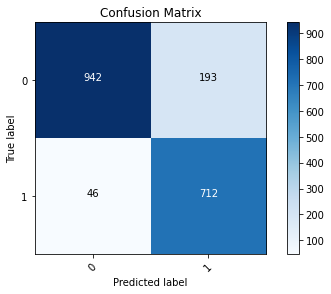

In [60]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, random_state=10)

scaler_norm = MinMaxScaler()
X_train = scaler_norm.fit_transform(X_train) 
X_test = scaler_norm.fit_transform(X_test) 

model_SVC = SVC(C=32)
model_SVC.fit(X_train, y_train) 

y_pred=model_SVC.predict(X_test)

cfm = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(cfm, classes = [0,1])


print(classification_report(y_test, y_pred))

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
print(X_train.shape)
print(y_train.shape)

scaler_norm = MinMaxScaler()
X_train = scaler_norm.fit_transform(X_train) 
X_test = scaler_norm.fit_transform(X_test) 


NN_Model = Sequential()
NN_Model.add(Dense(128, input_dim=256, activation='relu'))
NN_Model.add(Dropout(0.2))
NN_Model.add(Dense(64, activation='relu'))
NN_Model.add(Dropout(0.1))
NN_Model.add(Dense(32, activation='relu'))
NN_Model.add(Dense(2, activation='softmax'))

early_stopping = EarlyStopping(monitor = 'val_accuracy',patience = 5,mode = 'auto', min_delta = 0)

NN_Model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_Model.summary()

(10091, 256)
(10091, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 2)                 66        
                                                                 
Total params: 43,298
Trainable

In [65]:
NN_Model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data = (X_test, y_test), callbacks = [early_stopping])

Epoch 1/20
316/316 [==============================] - 1s 3ms/step - loss: 0.5645 - accuracy: 0.6998 - val_loss: 0.4056 - val_accuracy: 0.8327
Epoch 2/20
316/316 [==============================] - 1s 3ms/step - loss: 0.3323 - accuracy: 0.8619 - val_loss: 0.3888 - val_accuracy: 0.8268
Epoch 3/20
316/316 [==============================] - 1s 3ms/step - loss: 0.2912 - accuracy: 0.8796 - val_loss: 0.2486 - val_accuracy: 0.9017
Epoch 4/20
316/316 [==============================] - 1s 3ms/step - loss: 0.3065 - accuracy: 0.8705 - val_loss: 0.3783 - val_accuracy: 0.8391
Epoch 5/20
316/316 [==============================] - 1s 3ms/step - loss: 0.2896 - accuracy: 0.8752 - val_loss: 0.2484 - val_accuracy: 0.9057
Epoch 6/20
316/316 [==============================] - 1s 3ms/step - loss: 0.3098 - accuracy: 0.8694 - val_loss: 0.5839 - val_accuracy: 0.7095
Epoch 7/20
316/316 [==============================] - 1s 3ms/step - loss: 0.2820 - accuracy: 0.8776 - val_loss: 0.3271 - val_accuracy: 0.8613
Epoch 

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1490
           1       0.81      0.98      0.88      1033

    accuracy                           0.90      2523
   macro avg       0.90      0.91      0.89      2523
weighted avg       0.91      0.90      0.90      2523



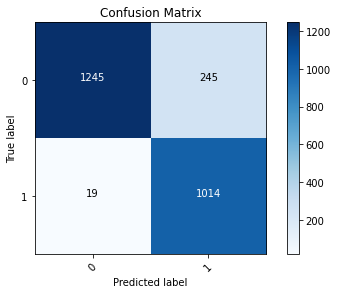

In [66]:
y_pred = NN_Model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 

cfm = confusion_matrix(y_test, y_pred_classes) 
plot_confusion_matrix(cfm, classes = [0,1])


print(classification_report(y_test, y_pred_classes))
